# Разработка A/B-тестирования и анализ результатов

### Задачи: 
 - рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

## 1. Работа с историческими данными (EDA)

### 1.1. Загрузка исторических данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

### 1.2. Знакомство с данными

In [3]:
# Подчет количества уникальных сессий для каждого пользователя
uniq_ses = sessions_history.groupby('user_id')['session_id'].nunique()

# Находжение id пользователя с максимальных количеством сессий
max_ses = uniq_ses.idxmax()

# Вывод данных их таблицы для этого пользователя
sessions_history[sessions_history['user_id'] == max_ses]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


### 1.3. Анализ числа регистраций

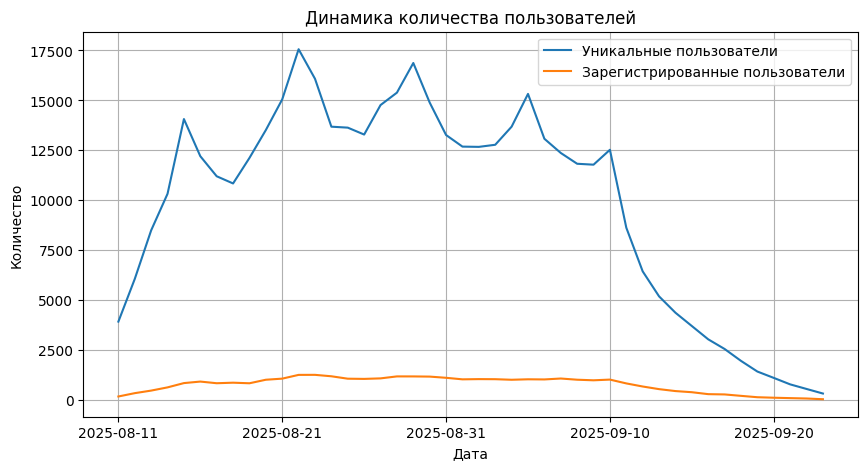

In [4]:
# Агрегирование данных
users = sessions_history.groupby('session_date').agg({'user_id': 'nunique', 'registration_flag': 'sum'})

# Визуализация динамики количества пользователей
users.plot(figsize=(10, 5))
plt.title('Динамика количества пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid()
plt.legend(('Уникальные пользователи', 'Зарегистрированные пользователи'))
plt.show()

Судя по графику количество не зарегистрированных пользователй гораздо больше чем зарегистрированных. \
В целом динамика общего количества пользователей по дням скачкообразная. Пики наблюдаются в основном по пятницам 15.08, 22.08, 29.08.
Динамика количества зарегистрированных пользователй плавная, резких скачков нет. 

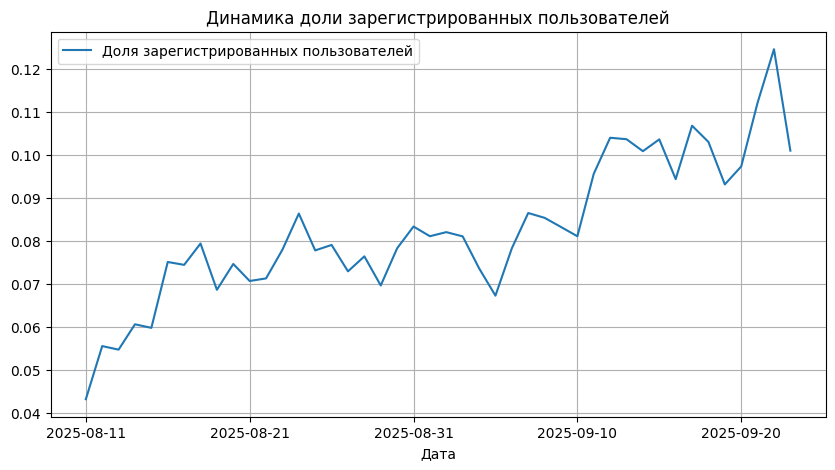

In [5]:
# Нахождение доли зарегистриванных пользователей
users['part'] = users['registration_flag'] / users['user_id'] 

# Визуализация доли зарегистриванных пользователей
users['part'].plot(figsize=(10, 5), label='Доля зарегистрированных пользователей')
plt.title('Динамика доли зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('')
plt.legend()
plt.grid()
plt.show()

Доля зарегистрированных пользователей показывает скачкообразный рост. Пик достигается 22.09.

### 1.4. Анализ числа просмотренных страниц


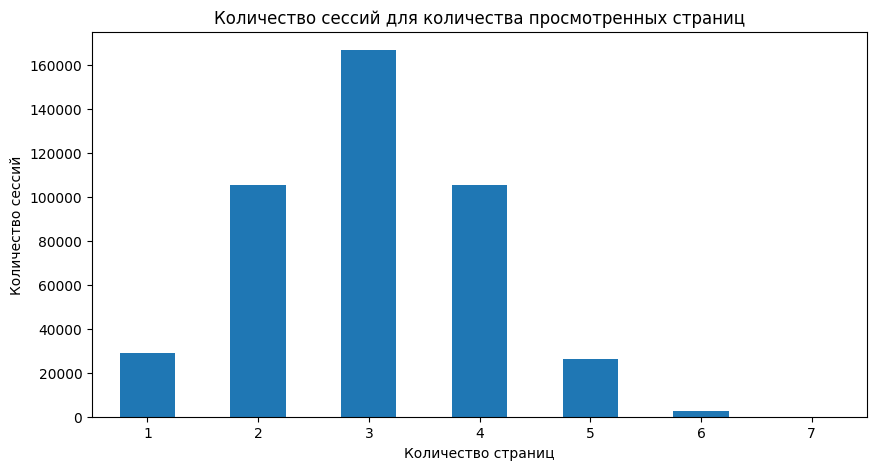

In [6]:
# Нахождение количества сессий для каждого количетсва страниц
pages = sessions_history.groupby('page_counter')['session_id'].count()

# Визуализация количетва сессий по страницам
pages.plot(kind='bar',
          figsize=(10, 5),
          rot=0)
plt.title('Количество сессий для количества просмотренных страниц')
plt.xlabel('Количество страниц')
plt.ylabel('Количество сессий')
plt.show()

В наибольшее количество сессий было просмотрено 3 страницы. Наименьшее количество сессий установлено для 7 страниц.


### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [7]:
# Функция для заполения столбца успешности сессии
def create_new_column(pages):
    if pages >= 4:
        return 1
    else:
        return 0

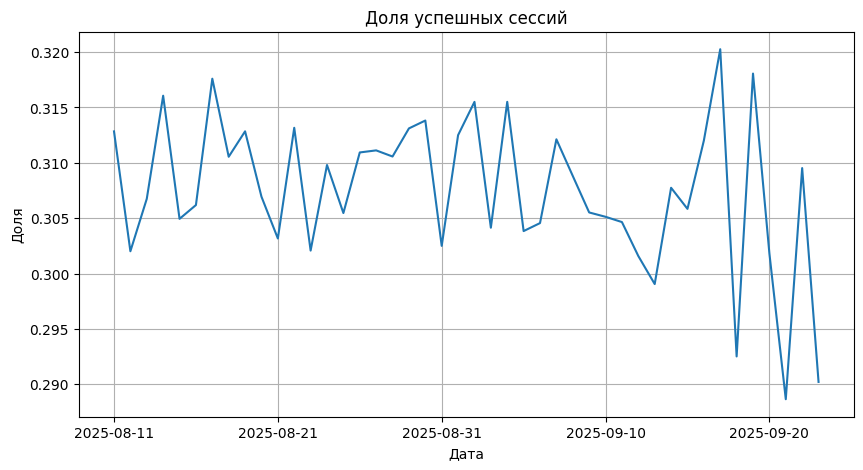

In [8]:
# Создание столбца успешности сессии
sessions_history['good_session'] = sessions_history['page_counter'].apply(create_new_column)

# Визуализация доли успешных сессий
sessions_history.groupby('session_date')['good_session'].mean().plot(figsize=(10, 5))
plt.title('Доля успешных сессий')
plt.xlabel('Дата')
plt.ylabel('Доля')
plt.grid()
plt.show()

График доли успешных сессий очень скачкообразен. Какую-то тенденцию сложно выделить.

In [9]:
# Расчет среднего значения доли успешных сессий 
(sessions_history.groupby('session_date')['good_session'].sum() / sessions_history.groupby('session_date')['session_id'].count()).mean() * 100

30.754410439546792

## 2. Подготовка к тесту
### Целевая метрика - доля упешных сессий (те сессий, где было просмотрено более 4 страниц)

### Расчёт размера выборки

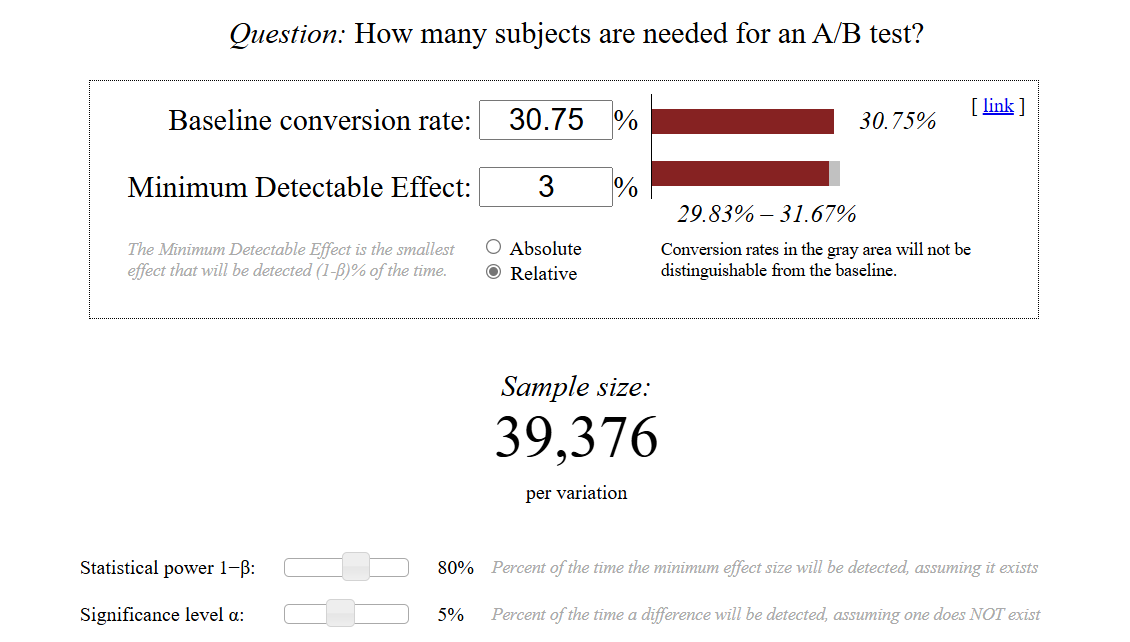

### 2.1. Расчёт длительности A/B-теста


In [11]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = users['user_id'].mean()

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(39376 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {round(avg_daily_users, 2)} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 4 дней


## 3. Мониторинг А/В-теста

### 3.1. Проверка распределения пользователей


In [12]:
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [13]:
# Расчет количества уникальных пользователей каждой группы для одного дня 
daily_un_users = sessions_test_part.groupby(['test_group', 'session_date'])['user_id'].nunique().reset_index()
avg_daily_users = daily_un_users.groupby('test_group')['user_id'].mean()

In [14]:
# Расчет процентной разницы по формуле
pers = round(100 * abs(avg_daily_users.iloc[0] - avg_daily_users.iloc[1]) / avg_daily_users.iloc[0], 2)
print(f'Разница между объемом групп А и В равна {pers}%')

Разница между объемом групп А и В равна 0.74%


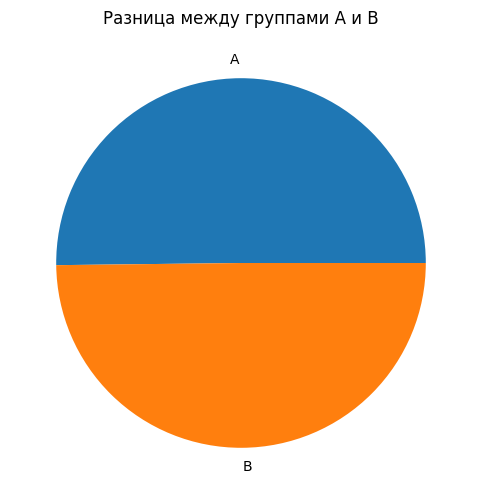

In [15]:
# Визуализация разницы между двумя группами
plt.figure(figsize=(6, 6))
avg_daily_users.plot(kind='pie')
plt.title('Разница между группами А и B')
plt.ylabel('')
plt.show()

 Так как разница между группами всего 0.74%, на визуализации ее практически не видно

### 3.2. Проверка пересечений пользователей

In [16]:
# Выборка id пользователей по группам
A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

# Проверка пересечения групп
intersection = list(set(A) & set(B))
intersection

[]

Проверка показала пустое множество, значит группы не пересекаются

### 3.3. Равномерность разделения пользователей по устройствам


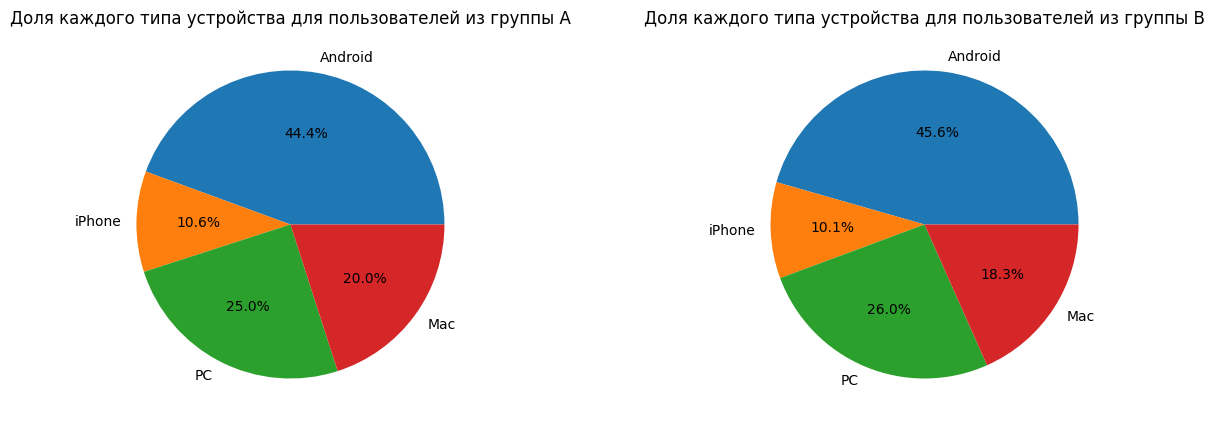

In [17]:
# Расчет долей каждого типа устройств по разным группам
A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() 
B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

# Подготовка подписей к долям
labels = sessions_test_part['device'].unique()

# Визуализация
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].pie(A, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Доля каждого типа устройства для пользователей из группы A')
axes[1].pie(B, labels=labels, autopct='%1.1f%%')
axes[1].set_title('Доля каждого типа устройства для пользователей из группы B')

plt.show()

### 3.4. Равномерность распределения пользователей по регионам


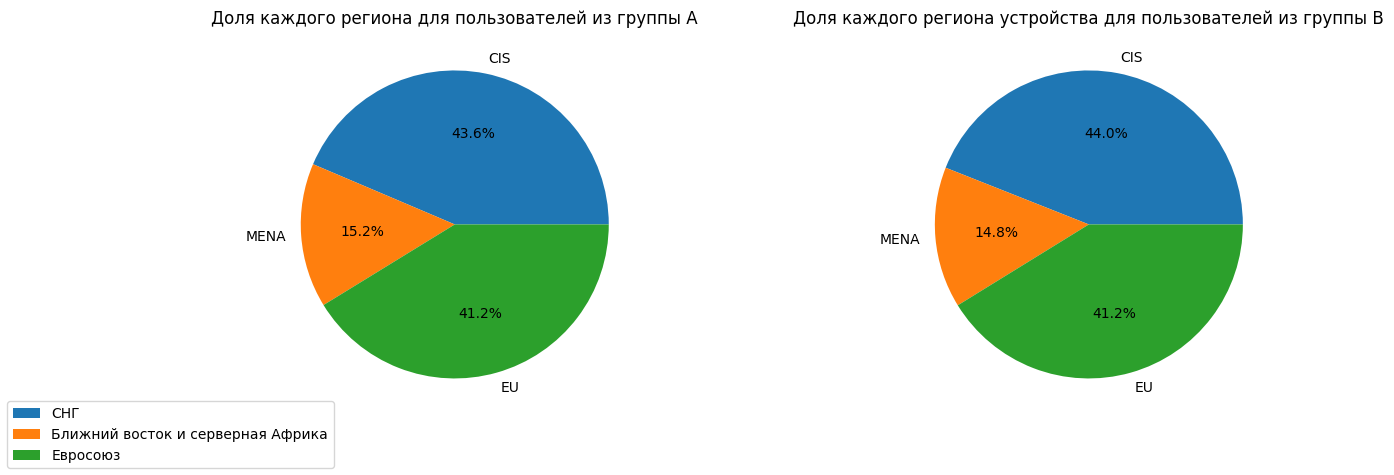

In [18]:
# Расчет долей каждого региона по разным группам
A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique() 
B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique() / sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()

# Подготовка подписей к долям
labels = sessions_test_part['region'].unique()

# Визуализация
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].pie(A, labels=labels, autopct='%1.1f%%')
axes[0].set_title('Доля каждого региона для пользователей из группы A')
axes[1].pie(B, labels=labels, autopct='%1.1f%%')
axes[1].set_title('Доля каждого региона устройства для пользователей из группы B')
fig.legend(['СНГ','Ближний восток и серверная Африка','Евросоюз'], loc=3)

plt.show()

### 3.5. Вывод 
- Да, между группами присудствует незначительное различие в 0,74%
- Выборки независимы, пересечния не обнаружены
- Распределение пользователей по категориальным переменным (устройства, регионы) примерно равномерное

## 4. Проверка результатов A/B-теста


### 4.1. Получение результатов теста и подсчёт основной метрики


In [19]:
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [20]:
# Создание столбца успешности сессии
sessions_test['good_session'] = sessions_test['page_counter'].apply(create_new_column)
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


### 4.2. Проверка корректности результатов теста


In [21]:
# Расчет количества уникальных сессий по дням и группам
sessions_number_per_day = sessions_test.groupby(['test_group','session_date'])['session_id'].nunique().reset_index()

Так как метрика не долевая, и по заданию нам нужно проверить равенство средних выборок, выбираем тест Стьюдента \
Н0: Выборочные средние в группах A и B равны \
Н1: Выборочные средние в группах A и B не равны

In [22]:
# Выборка для групп А и В
A = sessions_number_per_day[sessions_number_per_day.test_group=='A']['session_id']
B = sessions_number_per_day[sessions_number_per_day.test_group=='B']['session_id']

alpha = 0.05 # Задание уровня значимости


stat_ttest, p = ttest_ind(
    A, 
    B)

print(f'p-value = {round(p, 2)}')
if p > alpha:
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
else:
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны')

p-value = 0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны


### 4.3. Сравнение доли успешных сессий


In [23]:
# Подсчет долей успешных сессий для групп А и В
A = sessions_test[sessions_test.test_group=='A']['good_session'].sum() / sessions_test.shape[0] 
B = sessions_test[sessions_test.test_group=='B']['good_session'].sum() / sessions_test.shape[0]

# Подсчет разницы 
dif = B - A

print(f'Доля успешных сессий для группы А = {round(A, 2)}, для группы B = {round(B, 2)}, разница = {round(dif*100, 2)}%')

Доля успешных сессий для группы А = 0.15, для группы B = 0.16, разница = 0.81%


### 4.4. Насколько статистически значимо изменение ключевой метрики



Так как метрика долевая выбираем Z-тест\
Н0: Доли успешных сессий в группах A и B равны \
Н1: Доли успешных сессий в группе B больше чем в A

In [24]:
# Проверка достаточности данных
# Размеры выборок A и B
n_a, n_b = sessions_test[sessions_test.test_group=='A'].shape[0], sessions_test[sessions_test.test_group=='B'].shape[0] 
# Количество успешных сессий в группе A
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0] 
# Количество успешных сессий в группе В
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0] 
# Рассчитываем доли успешных сессий A и B
p_a, p_b = m_a/n_a, m_b/n_b 

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется')
else:
    print('Предпосылка о достаточном количестве данных не выполняется')

Предпосылка о достаточном количестве данных выполняется


In [25]:
# Проведение Z-теста
stats_ztest, p = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'p-value теста Z-теста = {p}')
if p > alpha:
    print('Нулевая гипотеза находит подтверждение! Изменение в метрике не является статистически значимым')
else:
    print('Нулевая гипотеза не находит подтверждения! Изменение в метрике является статистически значимым')

p-value теста Z-теста = 0.0001574739988036123
Нулевая гипотеза не находит подтверждения! Изменение в метрике является статистически значимым


Это значит новый алгоритм действителььно повлиял на рост доли успешных сессий, и рост это положительный

### 4.6. Вывод
* Количество пользователей 78752 человек, длительность эксперимента составлила 8 дней
* Внедрение нового алгоритма позволило добиться прироста целевой метрики
* P-value Z-теста составило 0.0001574739988036123
* Определенно проведение A/B теста показало, что новый алгоритм стоит ввести